In [1]:
%cd /home/yokoyama/research
from types import SimpleNamespace
import sys
import os
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

sys.path.append(".")
from modules.utils.video import Capture, Writer
from modules.pose import PoseDataHandler

/raid6/home/yokoyama/research


In [2]:
from submodules.i3d.pytorch_i3d import InceptionI3d
from torchvision.ops import roi_align

In [3]:
video_num = 1
cap = Capture(f"/raid6/home/yokoyama/datasets/dataset01/train/{video_num:02d}.mp4")
pose_data = PoseDataHandler.load(f"data/dataset01/train/{video_num:02d}", ["bbox"])

In [4]:
def load_frames_flows(cap, resize_ratio):
    frames = []
    w, h = cap.size
    flows = [np.zeros((int(h * resize_ratio), int(w * resize_ratio), 2))]
    for frame_num in tqdm(range(cap.frame_count)):
        frame_num += 1

        frame = cap.read()[1]
        frame = cv2.resize(frame, None, fx=resize_ratio, fy=resize_ratio)
        frames.append(frame)
        if frame_num == 1:
            continue

        pre_gray = cv2.cvtColor(frames[-2], cv2.COLOR_RGB2GRAY)
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        flow = cv2.calcOpticalFlowFarneback(pre_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        flows.append(flow)

    frames = (np.array(frames) / 255.) * 2 - 1
    flows = np.array(flows)

    return frames, flows

resize_ratio = 0.25
frames, flows = load_frames_flows(cap, resize_ratio)

100%|██████████| 5400/5400 [01:47<00:00, 50.32it/s]


In [5]:
def create_dataset(frames, flows, pose_data, frame_count, resize_ratio):
    dataset = []
    for frame_num in tqdm(range(frame_count)):
        frame_num += 1

        frame = frames[frame_num - 1]
        flow = flows[frame_num - 1]
        pose_data_frame = [data for data in pose_data if data["frame"] == frame_num]
        pids = [data["id"] for data in pose_data_frame]
        bboxs = [np.array(data["bbox"]) * resize_ratio for data in pose_data_frame]

        for pid, bbox in zip(pids, bboxs):
            x1, y1, x2, y2 = bbox.astype(int)
            frame_tmp = frame[y1:y2, x1:x2]
            flow_tmp = flow[y1:y2, x1:x2]

            dataset.append({"frame": frame_num, "id": pid, "bbox": bbox, "img": frame_tmp, "flow": flow_tmp})

    return dataset

dataset = create_dataset(frames, flows, pose_data, cap.frame_count, resize_ratio)

100%|██████████| 5400/5400 [00:07<00:00, 702.24it/s]


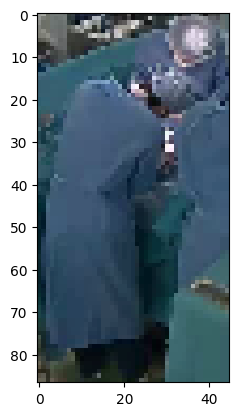

In [6]:
plt.imshow(((dataset[10]["img"] + 1) / 2 * 255).astype(np.uint8))

In [7]:
def create_batch(dataset, seq_len, start_frame_nums):
    batch = []
    for start_frame_num in tqdm(start_frame_nums):
        data_batch = {}
        for frame_num in range(seq_len):
            frame_num += start_frame_num

            for data in dataset:
                if data["frame"] != frame_num:
                    continue
                frame_num, pid, bbox, frame, flow = list(data.values())

                if pid not in data_batch:
                    data_batch[pid] = {"img": [], "flow": []}
                data_batch[pid]["img"].append(frame)
                data_batch[pid]["flow"].append(flow)

        for pid, data in data_batch.items():
            frames = []
            flows = []
            for frame, flow in zip(data["img"], data["flow"]):
                frames.append(cv2.resize(frame, (288, 384)))
                flows.append(cv2.resize(flow, (288, 384)))

            if len (frames) < seq_len:
                continue
            batch.append((start_frame_num, pid, np.array(frames), np.array(flows)))

    return batch

batch_num = 100
frame_length = 90
start_frame_num = 1545-100
# start_frame_nums = sorted(np.random.choice(cap.frame_count, batch_num, replace=True) + start_frame_num)
start_frame_nums = sorted(np.random.choice(100, batch_num, replace=False) + start_frame_num)
print(start_frame_nums)
batch = create_batch(dataset, frame_length, start_frame_nums)

[1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544]


100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


In [8]:
in_channels = 2

if in_channels == 3:
    # model_path = "submodules/i3d/models/rgb_imagenet.pt"
    model_path = "submodules/i3d/models/rgb_charades.pt"
elif in_channels == 2:
    tensor = torch.Tensor(flows)
    # model_path = "submodules/i3d/models/flow_imagenet.pt"
    model_path = "submodules/i3d/models/flow_charades.pt"

In [9]:
i3d = InceptionI3d(in_channels=in_channels)
# i3d.cuda(1)
i3d.replace_logits(157)
i3d.load_state_dict(torch.load(model_path))

# i3d = InceptionI3d(in_channels=in_channels, final_endpoint="Mixed_3b")
# i3d.build()
# i3d.cuda(1)
print("done")

done


In [17]:
output_size = 2

features = []
for data in tqdm(batch):
    if in_channels == 3:
        s, h, w, c = data[2].shape
        x = torch.Tensor(data[2].reshape(1, s, h, w, c))
    elif in_channels == 2:
        s, h, w, c = data[3].shape
        x = torch.Tensor(data[3].reshape(1, s, h, w, c))
    x = x.permute(0, 4, 1, 2, 3)
    for end_point in i3d.VALID_ENDPOINTS:
        if end_point in i3d.end_points:
            x = i3d._modules[end_point](x)
        if end_point == "Mixed_3b":
            break
    _, _, _, fy, fx = x.shape
    bbox = np.array([[0, 0, fx, fy]])
    x = roi_align(x, [torch.Tensor(bbox)], output_size, spatial_scale=fx / w)
    features.append(x.cpu().squeeze(0).detach().numpy())

features = np.array(features)
features.shape

100%|██████████| 193/193 [03:26<00:00,  1.07s/it]


(193, 256, 2, 2)

In [18]:
pids = list(set([data[1] for data in batch]))
pids

[1, 2, 6, 10, 11]

In [19]:
features_all = features.reshape(len(features), -1)
pca = PCA(n_components=2)
pca.fit(features_all)

embedding_dict = {}
for data, feature in zip(batch, tqdm(features)):
    frame_num = data[0]
    pid = data[1]
    if pid not in embedding_dict:
        embedding_dict[pid] = np.empty((0, 3))
    embedding = pca.transform(feature.reshape(1, -1))
    embedding = np.append(embedding, frame_num)
    embedding_dict[pid] = np.append(embedding_dict[pid], [embedding], axis=0)

 99%|█████████▉| 192/193 [00:00<00:00, 8142.14it/s]


In [20]:
print(start_frame_nums)

[1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544]


/tmp/ipykernel_2643578/2264242287.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


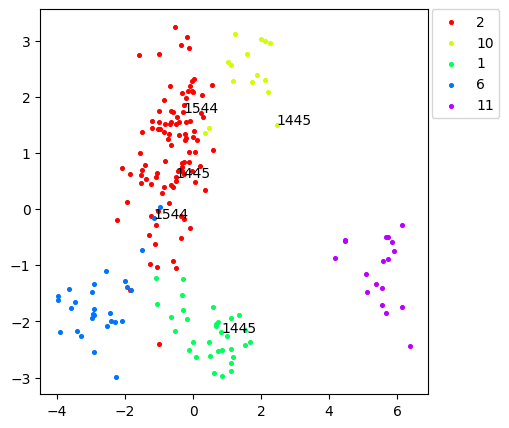

In [21]:
import matplotlib.cm as cm
plt.figure(figsize=(5, 5))
for i, (pid, embedding) in enumerate(embedding_dict.items()):
    # if i not in range(15, 20):
    #     continue
    plt.scatter(
        embedding[:, 0], embedding[:, 1], s=7, label=pid, c=cm.hsv(i / len(embedding_dict))
    )
    for j in range(len(embedding)):
        if embedding[j, 2] in start_frame_nums[::batch_num - 1]:
            plt.text(embedding[j, 0], embedding[j, 1], int(embedding[j, 2]))

# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(pids)
# plt.xlim((-65, 0))
# plt.ylim((-50, 50))
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.show()

In [22]:
features_all = features.reshape(len(features), -1)
um = umap.UMAP(n_neighbors=6, random_state=42)
um.fit(features_all)

embedding_dict = {}
for data, feature in zip(batch, tqdm(features)):
    frame_num = data[0]
    pid = data[1]
    if pid not in embedding_dict:
        embedding_dict[pid] = np.empty((0, 3))
    embedding = um.transform(feature.reshape(1, -1))
    embedding = np.append(embedding, frame_num)
    embedding_dict[pid] = np.append(embedding_dict[pid], [embedding], axis=0)

 99%|█████████▉| 192/193 [02:17<00:00,  1.40it/s]


/tmp/ipykernel_2643578/2264242287.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


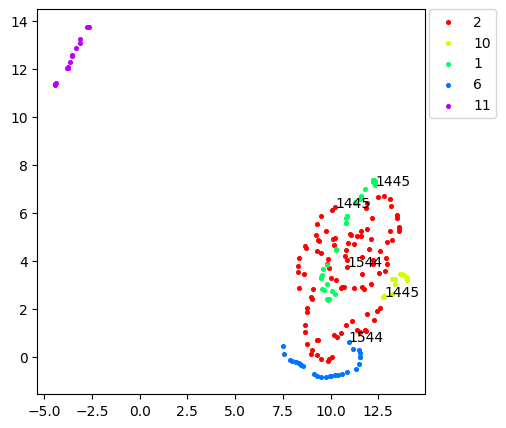

In [23]:
import matplotlib.cm as cm
plt.figure(figsize=(5, 5))
for i, (pid, embedding) in enumerate(embedding_dict.items()):
    # if i not in range(15, 20):
    #     continue
    plt.scatter(
        embedding[:, 0], embedding[:, 1], s=7, label=pid, c=cm.hsv(i / len(embedding_dict))
    )
    for j in range(len(embedding)):
        if embedding[j, 2] in start_frame_nums[::batch_num - 1]:
            plt.text(embedding[j, 0], embedding[j, 1], int(embedding[j, 2]))

# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(pids)
# plt.xlim((-65, 0))
# plt.ylim((-50, 50))
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.show()